In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pyuvdata
import numpy as np
import pyuvsim
import os

In [2]:
df = pd.read_excel("/Users/ruby/Downloads/LWA-352 Antenna Status & System Configuration.xlsx", header=1)

In [3]:
df.keys()

Index(['dict_key', 'antname', 'ant_type', 'latitude', 'longitude', 'elevation',
       'x', 'y', 'used', 'online', 'pola_fee', 'polb_fee', 'pola_resistance',
       'polb_resistance', 'arx_location', 'arx_serial', 'arx_address',
       'pola_arx_channel', 'check1', 'polb_arx_channel', 'check2',
       'snap2_serial', 'snap2_chassis', 'snap2_location', 'snap2_mac',
       'snap2_hostname', 'fmc', 'pola_digitizer_channel',
       'polb_digitizer_channel', 'pola_fpga_num', 'polb_fpga_num', 'corr_num',
       'notes', 'Unnamed: 33', 'Unnamed: 34', 'Unnamed: 35'],
      dtype='object')

In [4]:
ant_names = []
ant_lat = []
ant_lon = []
ant_elevation = []
antenna_xlocs = []
antenna_ylocs = []
for ant_ind in range(1, len(df['used'])):
    if df['used'][ant_ind] == 'YES':
        ant_names.append(df['antname'][ant_ind])
        ant_lat.append(df['latitude'][ant_ind])
        ant_lon.append(df['longitude'][ant_ind])
        ant_elevation.append(df['elevation'][ant_ind])
        antenna_xlocs.append(df['x'][ant_ind])
        antenna_ylocs.append(df['y'][ant_ind])

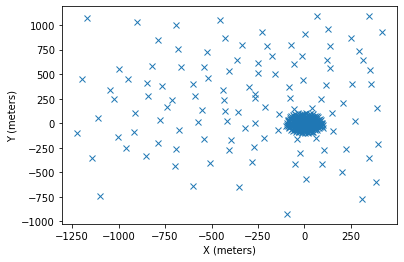

In [5]:
plt.plot(antenna_xlocs, antenna_ylocs, 'x')
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.show()

In [6]:
Nants = len(antenna_xlocs)
antenna_locs_ENU = np.zeros((Nants, 3))
antenna_locs_ENU[:, 0] = antenna_xlocs
antenna_locs_ENU[:, 1] = antenna_ylocs

#filename = '/home/ubuntu/1061316296.uvfits'
UV = pyuvdata.UVData()
#UV.read_uvfits(filename)

UV.Nants_data = Nants
UV.Nants_telescope = Nants
UV.Nspws = 1
UV.Npols = 2
UV.x_orientation = 'east'
UV.polarization_array = np.array([-5, -6])  # Polarizations are XX, YY
UV.phase_type = 'drift'
UV.vis_units = 'Jy'
UV.Nfreqs = 1
UV.channel_width = 24. * 1e3
UV.freq_array = np.full((1,1), 85. * 1e6)
UV.history = 'stand-in OVRO-LWA obs for simulation'
UV.object_name = 'testfield1'
UV.spw_array = np.array([0])

# Load known telescope data for telescope location
lwa_obj = pyuvdata.telescopes.get_telescope('OVRO-LWA')
UV.instrument = lwa_obj.telescope_name
UV.telescope_name = lwa_obj.telescope_name
UV.telescope_location = lwa_obj.telescope_location

# Get time data
time_extent_s = 10.
integration_time_s = .1
# Get central time from a random data file
time_ref = pyuvdata.UVData()
time_ref.read_uvfits('/Users/ruby/Astro/LWA_data/2019-11-21T23:00:08.uvfits')
mean_time = np.mean(time_ref.time_array)
time_array_s = np.arange(0, time_extent_s, integration_time_s)
UV.Ntimes = len(time_array_s)
UV.Nbls = int((Nants**2 - Nants)/2)
UV.Nblts = UV.Nbls*UV.Ntimes
UV.integration_time = np.full(UV.Nblts, integration_time_s)
time_array_days = time_array_s/(60.**2*24.)
time_array_jd = time_array_days + mean_time - np.mean(time_array_days)
UV.time_array = np.repeat(np.array(time_array_jd), UV.Nbls)
UV.set_lsts_from_time_array()  # Populate lst_array

# Create baseline array
UV.antenna_numbers = np.array(range(Nants), dtype=int)
UV.antenna_names = ant_names
ant_1_array = np.zeros(UV.Nbls, dtype=int)
ant_2_array = np.zeros(UV.Nbls, dtype=int)
baseline_array = np.zeros(UV.Nbls, dtype=int)
index = 0
for ant1 in range(Nants-1):
    for ant2 in range(ant1+1, Nants):
        ant_1_array[index] = ant1
        ant_2_array[index] = ant2
        baseline_array[index] =  2048 * (ant1+1) + (ant2+1) + 2**16
        index += 1
UV.ant_1_array = np.tile(ant_1_array, UV.Ntimes)
UV.ant_2_array = np.tile(ant_2_array, UV.Ntimes)
UV.baseline_array = np.tile(baseline_array, UV.Ntimes)

# Add dummy data
UV.data_array = np.full(
    (UV.Nblts, UV.Nspws, UV.Nfreqs, UV.Npols), 0., dtype=complex
)
UV.nsample_array = np.full(
    (UV.Nblts, UV.Nspws, UV.Nfreqs, UV.Npols), 1., dtype=float
)
# Unflag all
UV.flag_array = np.full(
    (UV.Nblts, UV.Nspws, UV.Nfreqs, UV.Npols), False, dtype=bool
)
# Calculate UVWs
UV.uvw_array = np.zeros((UV.Nblts, 3), dtype=float)
antenna_locs_ECEF = pyuvdata.utils.ECEF_from_ENU(
    antenna_locs_ENU, *UV.telescope_location_lat_lon_alt
)
UV.antenna_positions = antenna_locs_ECEF - UV.telescope_location
UV.set_uvws_from_antenna_positions(
    allow_phasing=False, orig_phase_frame='gcrs', output_phase_frame='icrs'
)
UV.phase_center_frame = 'icrs'

UV.check()

Telescope OVRO_MMA is not in known_telescopes.
Fixing auto-correlations to be be real-only, after some imaginary values were detected in data_array.


True

In [8]:
#UV.phase_to_time(np.mean(UV.time_array))  # Data needs to be phased to write a uvfits file
#uvfits_save_filename = "/Users/ruby/Astro/LWA_pyuvsim_simulations/lwa_100ms.uvfits"
#UV.write_uvfits(uvfits_save_filename, spoof_nonessential=True)

In [9]:
path, telescope_config, layout_fname = pyuvsim.simsetup.uvdata_to_telescope_config(
    UV, 
    "/Users/ruby/Astro/LWA_beams/LWAbeam_2015_new.fits",
    path_out="/Users/ruby/Astro/LWA_pyuvsim_simulations/",
    return_names = True
)

Path: /Users/ruby/Astro/LWA_pyuvsim_simulations/, telescope_config: telescope_config_OVRO-LWA.yaml, layout: OVRO-LWA_layout.csv


In [10]:
pyuvsim.simsetup.uvdata_to_config_file(
    UV,
    telescope_config_name=os.path.join(path, telescope_config),
    layout_csv_name=os.path.join(path, layout_fname),
    path_out=path
)